# Legendre KAN

##Legendre basis function up til 4th degree

    """
    Returns tensor B ∈ ℝ^{…, degree+1} with P̃0 … P̃_degree evaluated at x.
    (All five polynomials are computed, then trimmed for simplicity.)

    #     P̃0(x) = 1                                     (identity)
    #     P̃1(x) = √3 (2x − 1)                           (~mean)
    #     P̃2(x) = √5 (6x² − 6x + 1)                     (~variance)
    #     P̃3(x) = √7 (20x³ − 30x² + 12x − 1)            (~skewness)
    #     P̃4(x) = 3  (70x⁴ − 140x³ + 90x² − 20x + 1)    (~kurtosis)

    """

In [ ]:
import torch, torch.nn as nn
import math


SQRT3, SQRT5, SQRT7 = map(math.sqrt, (3.0, 5.0, 7.0))

#Main table for
table = torch.tensor(
    [
        [1.0,               0.0,               0.0,               0.0,               0.0],
        [-SQRT3,            2 * SQRT3,         0.0,               0.0,               0.0],
        [SQRT5,            -6 * SQRT5,         6 * SQRT5,         0.0,               0.0],
        [-SQRT7,           12 * SQRT7,        -30 * SQRT7,        20 * SQRT7,        0.0],
        [3.0,             -60.0,             270.0,             -420.0,             210.0],
    ],
    dtype=torch.float32,
)

def _make_legendre_polynomials(max_degree: int = 4, *, dtype=torch.float32):
    return table[: max_degree + 1, : max_degree + 1]


##KAN Layer
    """
    KAN building-block that projects each input feature onto the first
    (degree+1) shifted/orthonormal Legendre polynomials listed above.
    """

In [ ]:
class LegendreKANLayer(nn.Module):
    MAX_DEGREE = 4

    def __init__(self, input_dim: int, output_dim: int, degree: int = 4, shifted=False):
        super().__init__()

        if not (0 <= degree <= self.MAX_DEGREE):
            raise ValueError(f"`degree` must be in [0, {self.MAX_DEGREE}]")

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.degree = degree

        leg_table = _make_legendre_polynomials(self.MAX_DEGREE, dtype=torch.get_default_dtype())
        self.register_buffer("legendre_table", leg_table, persistent=False)  # 5×5

        self.legendre_coeffs = nn.Parameter(
            torch.empty(input_dim, output_dim, degree + 1)
        )
        nn.init.normal_(
            self.legendre_coeffs,
            mean=0.0,
            std=1 / (input_dim * (degree + 1)),
        )

    def _legendre_basis(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute [P0(x) … P_degree(x)] for every feature value in `x`.

        x : (batch, input_dim) already scaled to [0, 1]
        returns : (batch, input_dim, degree+1)
        """
        powers = x.unsqueeze(-1) ** torch.arange(0, self.MAX_DEGREE + 1,
                                                 device=x.device,
                                                 dtype=x.dtype)            # (B, I, 5)

        basis_full = torch.matmul(powers, self.legendre_table.t())          # (B, I, 5)
        return basis_full[..., : self.degree + 1]                           # (B, I, D+1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x : (batch, input_dim) already scaled to [0, 1]
        returns : (batch, output_dim)
        """
        if x.shape[-1] != self.input_dim:
            raise ValueError(
                f"Expected last dimension = {self.input_dim}, got {x.shape[-1]}"
            )

        basis = self._legendre_basis(x)
        return torch.einsum("bid,iod->bo", basis, self.legendre_coeffs)


##Normalizers

Gaussian CDF Norm:
1. first standardize each feature (z)
2. Apply normal CDF (u = 1/2 * (1+ erf(z/sqr(2))))
3. Apply learnable parameters if affine set to true. (u = u*weight + bias)


Empirical CDF Norm:
1. sort each feature in the mini-batch
2. replace each value by its rank divided by N (N is numbers of examples in the mini_batch, so essentialy .shape[0])

In [ ]:
class GaussianCDFNorm(nn.Module):
    def __init__(self, unbiased: bool = True, affine: bool = False,
                 eps: float = 1e-5):
        super().__init__()
        self.unbiased = unbiased
        self.eps = eps

        #affine means stat-only, no learnable params for the sake of research
        if affine:
            self.weight = nn.Parameter(torch.ones(1))  # broadcast over features
            self.bias   = nn.Parameter(torch.zeros(1))
        else:
            self.register_parameter("weight", None)
            self.register_parameter("bias",   None)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        mu  = x.mean(dim=0, keepdim=True)
        var = x.var(dim=0, unbiased=self.unbiased, keepdim=True)
        z   = (x - mu) / (var + self.eps).sqrt()

        u = 0.5 * (1.0 + torch.erf(z / math.sqrt(2.0)))

        if self.weight is not None:
            u = u * self.weight + self.bias
        return u


class EmpiricalCDFNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        sorted_x, _ = torch.sort(x, dim=0)
        idx = torch.searchsorted(sorted_x, x)
        N   = x.shape[0]
        return (idx.to(x.dtype) + 0.5) / N

## KAN Architecture

Now this is a bit tricky. I applied the possibliity to switch between gaussian and empirical as the normalizer.

Current architecture looks like this:
1. Normalize any input to [0,1]
2. Perform KAN Layer (calculate the output of legendre polynomials on the data)
3. Again normalize the output to [0,1]
4. Perform KAN Layer (calculate the output of legendre polynomials on the data)
5. Again normalize the output to [0,1]
6. Perform KAN Layer (calculate the output of legendre polynomials on the data)

Here to be honest im not sure about the architecture, i'd love to get some pointers. Should inter-layer normalizations stay the same as the first normalization? Jarek talked about this calibration, but i believe the calibration should happen only after 25 degrees? or sth like that



In [ ]:
from typing import Literal
import torch.nn as nn

class LegendreKAN(nn.Module):
    """
    Legendre Kernel Adaptive Network (KAN)

    Args
    ----
    norm : {"gaussian", "empirical"}
        Inter-layer normalisation strategy.
    degree : int
        Degree of the Legendre polynomial basis.
    shifted : bool
        Whether to use shifted Legendre polynomials (domain [0,1] instead of [-1,1]).
    """
    def __init__(
        self,
        norm: Literal["gaussian", "empirical"] = "gaussian",
        degree: int = 4,
        shifted: bool = False
    ):
        super().__init__()
        self.shifted = shifted

        def _make_norm():
            if norm == "gaussian":
                return GaussianCDFNorm(unbiased=False)
            elif norm == "empirical":
                return EmpiricalCDFNorm()
            else:
                raise ValueError(f"norm must be 'gaussian' or 'empirical', got {norm!r}")

        self.norm0 = _make_norm()
        self.kan1  = LegendreKANLayer(28 * 28, 32, degree, shifted=self.shifted)
        self.norm1 = _make_norm()

        self.kan2  = LegendreKANLayer(32, 16, degree, shifted=self.shifted)
        self.norm2 = _make_norm()

        self.kan3  = LegendreKANLayer(16, 10, degree, shifted=self.shifted)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.norm0(x)
        x = self.kan1(x)
        x = self.norm1(x)
        x = self.kan2(x)
        x = self.norm2(x)
        x = self.kan3(x)
        return x


#Smoke tests for normalizations

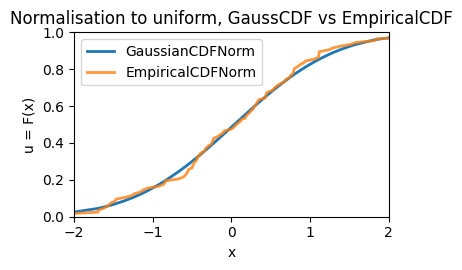

In [ ]:

import torch, torch.nn as nn
import matplotlib.pyplot as plt

N   = 100
torch.manual_seed(0)
dat = torch.randn(N)

gcn = GaussianCDFNorm(unbiased=False) #match with the Jarek's Mathematica code.
ecn = EmpiricalCDFNorm()

with torch.no_grad():
    u_g = gcn(dat)
    u_e = ecn(dat)

x_sorted, idx = torch.sort(dat)          # x(1) ≤ … ≤ x(N) sorting because matplotlib draws it as a polyline.
u_g_sorted    = u_g[idx]
u_e_sorted    = u_e[idx]

plt.figure(figsize=(4,2.8))
plt.plot(x_sorted, u_g_sorted, label='GaussianCDFNorm', lw=2)
plt.plot(x_sorted, u_e_sorted, label='EmpiricalCDFNorm', lw=2, alpha=.8)
plt.xlim(-2, 2); plt.ylim(0, 1)
plt.xlabel('x');  plt.ylabel('u = F(x)')
plt.title('Normalisation to uniform, GaussCDF vs EmpiricalCDF')
plt.legend(); plt.tight_layout()
plt.show()


#Training

##MNIST

###Load the data and helper functions

Loss Function:
- CrossEntropyLoss to compare 2 distributions (negative log likelihood)
- utilize Adam as optimizer, and thats pretty much it

TODO:
- learning-rate warm-up

In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


#HYPERPARAMETERS
BATCH_SIZE   = 128
EPOCHS       = 15
LR           = 1e-3 #0.001
WEIGHT_DECAY = 1e-4 #0.0001


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_ds = datasets.MNIST(root="./data", train=True,  download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = LegendreKAN(norm="gaussian", degree=4).to(device)

opt = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()

def accuracy(logits, targets):
    return (logits.argmax(dim=1) == targets).float().mean()

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_acc, total_size = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        total_acc  += accuracy(logits, y) * x.size(0)
        total_size += x.size(0)
    return (total_acc / total_size).item()

###run the training loop
TODO:
- test with shifted polynomials

In [ ]:
for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        opt.zero_grad()
        logits = model(x)
        loss   = criterion(logits, y)
        loss.backward()
        opt.step()

        running_loss += loss.item() * x.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    val_acc    = evaluate(test_loader)

    print(f"Epoch {epoch:02d}/{EPOCHS}  "
          f"loss={train_loss:.4f}  "
          f"val-acc={val_acc*100:5.2f}%")

Epoch 01/15  loss=0.5552  val-acc=94.00%
Epoch 02/15  loss=0.1806  val-acc=94.72%
Epoch 03/15  loss=0.1262  val-acc=94.91%
Epoch 04/15  loss=0.0982  val-acc=95.29%
Epoch 05/15  loss=0.0802  val-acc=95.35%
Epoch 06/15  loss=0.0666  val-acc=95.35%
Epoch 07/15  loss=0.0587  val-acc=95.38%
Epoch 08/15  loss=0.0526  val-acc=95.62%
Epoch 09/15  loss=0.0445  val-acc=95.67%
Epoch 10/15  loss=0.0452  val-acc=95.54%
Epoch 11/15  loss=0.0356  val-acc=95.67%
Epoch 12/15  loss=0.0368  val-acc=95.73%
Epoch 13/15  loss=0.0309  val-acc=95.76%
Epoch 14/15  loss=0.0302  val-acc=95.28%
Epoch 15/15  loss=0.0302  val-acc=95.44%


###run predictions

In [ ]:
model.eval()
running_loss = 0.0
all_preds, all_targets = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss   = criterion(logits, y)

        running_loss += loss.item() * x.size(0)
        all_preds.append(logits.argmax(dim=1).cpu())
        all_targets.append(y.cpu())

test_loss = running_loss / len(test_loader.dataset)
y_pred = torch.cat(all_preds)
y_true = torch.cat(all_targets)
accuracy = (y_pred == y_true).float().mean().item()

print(f"\nTest cross-entropy : {test_loss:.4f}")
print(f"Test accuracy      : {accuracy*100:5.2f} %")



Test cross-entropy : 0.1636
Test accuracy      : 95.44 %


###Confusion matrix

In [ ]:
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(1)

print("\nPer-class accuracy")
for cls, acc in enumerate(per_class_acc):
    print(f"  {cls} : {acc*100:5.2f} %")

print("\nDetailed report:")
print(classification_report(y_true, y_pred, digits=4))

print("\nConfusion matrix")
print(cm)


Per-class accuracy
  0 : 97.35 %
  1 : 98.15 %
  2 : 95.16 %
  3 : 94.36 %
  4 : 94.30 %
  5 : 94.28 %
  6 : 96.66 %
  7 : 94.84 %
  8 : 95.07 %
  9 : 93.86 %

Detailed report:
              precision    recall  f1-score   support

           0     0.9656    0.9735    0.9695       980
           1     0.9824    0.9815    0.9819      1135
           2     0.9534    0.9516    0.9525      1032
           3     0.9380    0.9436    0.9408      1010
           4     0.9497    0.9430    0.9463       982
           5     0.9524    0.9428    0.9476       892
           6     0.9596    0.9666    0.9631       958
           7     0.9596    0.9484    0.9540      1028
           8     0.9354    0.9507    0.9430       974
           9     0.9442    0.9386    0.9414      1009

    accuracy                         0.9544     10000
   macro avg     0.9540    0.9540    0.9540     10000
weighted avg     0.9544    0.9544    0.9544     10000


Confusion matrix
[[ 954    0    3    2    1    4   11    1    